<a href="https://colab.research.google.com/github/esgantivar/qmc/blob/torch/examples/torch/dmkdc-tn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/esgantivar/qmc.git@torch -q
else:
    import sys
    sys.path.insert(0, '../../')

In [17]:
import torch
import numpy as np
import tensornetwork as tn
from qmc.torch.models import DMKDClassifierTNSGD, DMKDClassifier
from qmc.torch.layers import QFeatureMapRFF
from qmc.torch.utils import get_moons
import torch.nn.functional as F

In [5]:
tn.set_default_backend('pytorch')

In [6]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    X = X.numpy()
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return (clf(torch.tensor(X, dtype=torch.float))).detach().numpy()[:, 1]
    return pred_fun

In [215]:
(X, y), (x_train, y_train), (x_test, y_test) = get_moons()
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.nn.functional.one_hot(torch.tensor(y_train)).to(torch.float)
y_test =  torch.nn.functional.one_hot(torch.tensor(y_test)).to(torch.float)

In [8]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.nn.functional.one_hot(torch.tensor(y_train)).to(torch.float)
y_test =  torch.nn.functional.one_hot(torch.tensor(y_test)).to(torch.float)

In [9]:
tn_dmkdc = DMKDClassifierTNSGD(
    input_dim=2,
    dim_x=150,
    num_classes=2,
    num_eig=50,
    gamma=20,
    random_state=17
)

In [10]:
optimizer = torch.optim.Adam(tn_dmkdc.parameters(), lr=0.5)
loss_fn = torch.nn.BCELoss()

In [11]:
for _ in range(20):
    correct = 0
    y_pred = tn_dmkdc(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    for i in range(len(y_pred)):
        if torch.argmax(y_pred[i]) == torch.argmax(y_train[i]):
            correct += 1
    print(correct/len(y_pred))
    loss.backward()
    optimizer.step()

0.376865671641791
0.8716417910447761
0.9432835820895522
0.9626865671641791
0.9694029850746269
0.9619402985074627
0.9634328358208956
0.9701492537313433
0.9708955223880597
0.9708955223880597
0.9716417910447761
0.9716417910447761
0.9708955223880597
0.9694029850746269
0.9738805970149254
0.9746268656716418
0.9768656716417911
0.9776119402985075
0.9768656716417911
0.9776119402985075


In [14]:
out = tn_dmkdc(x_test)
out[:10]

tensor([[0.1090, 0.8910],
        [0.8669, 0.1331],
        [0.0337, 0.9663],
        [0.0396, 0.9604],
        [0.7819, 0.2181],
        [0.9034, 0.0966],
        [0.0626, 0.9374],
        [0.0306, 0.9694],
        [0.9338, 0.0662],
        [0.0387, 0.9613]], grad_fn=<SliceBackward>)

0.022461245 0.022461245


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


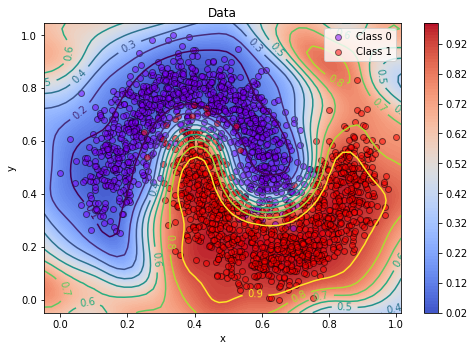

In [254]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(x_test, gen_pred_fun(tn_dmkdc))
plot_data(X, y)

In [255]:
from qmc.torch.utils_layers import CrossProduct

In [256]:
class DMKDClassifier(torch.nn.Module):
    def __init__(self, fm_x, dim_x, num_classes=2):
        super(DMKDClassifier, self).__init__()
        self.fm_x = fm_x
        self.dim_x = dim_x
        self.num_classes = num_classes
        self.qmd = []
        for _ in range(num_classes):
            self.qmd.append(QMeasureDensityTN(dim_x))
        self.cp = CrossProduct()
        self.num_samples = torch.zeros((num_classes,))

    def calc_batch_train(self, x, y):
        psi = self.fm_x(x)  # shape (bs, dim_x)
        rho = self.cp([psi, torch.conj(psi)])  # shape (bs, dim_x, dim_x)
        ohy = torch.reshape(y, (-1, self.num_classes))
        num_samples = torch.squeeze(torch.sum(ohy, dim=0))
        ohy = torch.unsqueeze(ohy, dim=-1)
        ohy = torch.unsqueeze(ohy, dim=-1)  # shape (bs, num_classes, 1, 1)
        rhos = ohy * torch.unsqueeze(rho, dim=1)  # shape (bs, num_classes, dim_x, dim_x)
        rhos = torch.sum(rhos, dim=0)  # shape (num_classes, dim_x, dim_x)
        self.num_samples += num_samples
        return rhos

    def calc_train(self, x, y):
        rhos = self.calc_batch_train(x, y)
        for i in range(self.num_classes):
            self.qmd[i].rho += rhos[i]
        for i in range(self.num_classes):
            self.qmd[i].rho /= self.num_samples[i]

    def forward(self, inputs):
        # Quantum feature mapping
        psi_x = self.fm_x(inputs)
        probs = []
        # Prediction operator
        for i in range(self.num_classes):
            probs.append(self.qmd[i](psi_x))
        posteriors = torch.stack(probs, dim=-1)
        posteriors = (posteriors / torch.unsqueeze(torch.sum(posteriors, dim=-1), dim=-1))
        # Partial trace => argmax over posteriors
        return posteriors

In [257]:
class QMeasureDensityTN(torch.nn.Module):
    def __init__(
            self,
            dim_x: int
    ):
        super(QMeasureDensityTN, self).__init__();
        self.dim_x = dim_x
        self._build()

    def _build(self):
        self.rho = torch.zeros(self.dim_x, self.dim_x)

    def forward(self, inputs):
        def f(oper, rho):
            # Create nodes
            node = tn.Node(oper)
            nrho = tn.Node(rho)
            node[0] ^ nrho[0]
            nrho[1] ^ node[1]
            ans = tn.contractors.greedy(tn.reachable(node))
            return ans.tensor
        
        opers = torch.einsum(
            '...i,...j->...ij',
            inputs,
            torch.conj(inputs)
        )
        return torch.stack([f(vec, self.rho) for vec in opers])

In [258]:
fm_x = QFeatureMapRFF(2, dim=10, gamma=20, random_state=17)
model = DMKDClassifier(fm_x=fm_x, dim_x=10, num_classes=2)
model.calc_train(x_train, y_train)
out = model(x_test)
out[:10]

tensor([[0.1327, 0.8673],
        [0.4994, 0.5006],
        [0.3193, 0.6807],
        [0.2943, 0.7057],
        [0.4607, 0.5393],
        [0.7827, 0.2173],
        [0.4335, 0.5665],
        [0.3809, 0.6191],
        [0.7299, 0.2701],
        [0.3999, 0.6001]], grad_fn=<SliceBackward>)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.08059126 0.08059126


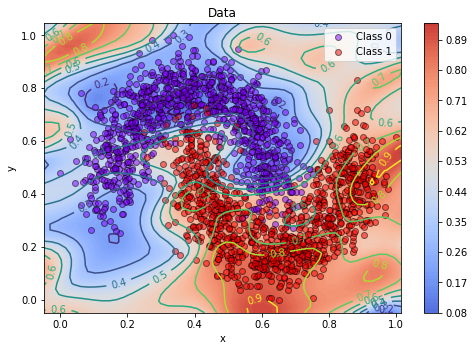

In [259]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(x_test, gen_pred_fun(model))
plot_data(X, y)

In [260]:
x_train.shape, y_train.shape

(torch.Size([1340, 2]), torch.Size([1340, 2]))

In [261]:
i = fm_x(x_train)
i.shape

torch.Size([1340, 10])

In [265]:

oper = torch.einsum('...i,...j->...ij',i, torch.conj(i))
oper.shape

torch.Size([1340, 10, 10])

In [268]:
rho = torch.zeros((10, 2, 10, 2))
rho.shape

torch.Size([10, 2, 10, 2])

In [269]:
rho_res = torch.einsum('...ik, klmn, ...mo -> ...ilon', oper, rho, oper)
rho_res.shape

torch.Size([1340, 10, 2, 10, 2])

In [271]:
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [318]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [315]:
X, y = make_moons(n_samples=2000, noise=0.2, random_state=0)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [301]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_train.shape

(1340, 2)

In [312]:
from qmc.tf import layers
from qmc.tf.layers import QFeatureMapRFF
from qmc.tf.models import QMClassifier
from qmc.tf import layers

In [282]:
class QMClassifier(tf.keras.Model):
    """
    A Quantum Measurement Classifier model.
    Arguments:
        fm_x: Quantum feature map layer for inputs
        fm_y: Quantum feature map layer for outputs
        dim_x: dimension of the input quantum feature map
        dim_y: dimension of the output representation
    """
    def __init__(self, fm_x, fm_y, dim_x, dim_y):
        super(QMClassifier, self).__init__()
        self.fm_x = fm_x
        self.fm_y = fm_y
        self.qm = layers.QMeasureClassif(dim_x=dim_x, dim_y=dim_y)
        self.dm2dist = layers.DensityMatrix2Dist()
        self.cp1 = layers.CrossProduct()
        self.cp2 = layers.CrossProduct()
        self.num_samples = tf.Variable(
            initial_value=0.,
            trainable=False     
            )

    def call(self, inputs):
        psi_x = self.fm_x(inputs)
        rho_y = self.qm(psi_x)
        probs = self.dm2dist(rho_y)
        return probs

    @tf.function
    def call_train(self, x, y):
        if not self.qm.built:
            self.call(x)
        psi_x = self.fm_x(x)
        psi_y = self.fm_y(y)
        psi = self.cp1([psi_x, psi_y])
        rho = self.cp2([psi, tf.math.conj(psi)])
        num_samples = tf.cast(tf.shape(x)[0], rho.dtype)
        rho = tf.reduce_sum(rho, axis=0)
        self.num_samples.assign_add(num_samples)
        return rho

    def train_step(self, data):
        x, y = data
        rho = self.call_train(x, y)
        self.qm.weights[0].assign_add(rho)
        return {}

    def fit(self, *args, **kwargs):
        result = super(QMClassifier, self).fit(*args, **kwargs)
        self.qm.weights[0].assign(self.qm.weights[0] / self.num_samples)
        return result

    def get_rho(self):
        return self.qm.rho

    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "dim_y": self.dim_y
        }
        base_config = super().get_config()
        return {**base_config, **config}

In [307]:
class QMeasureClassif(tf.keras.layers.Layer):
    """Quantum measurement layer for classification.

    Input shape:
        (batch_size, dim_x)
        where dim_x is the dimension of the input state
    Output shape:
        (batch_size, dim_y, dim_y)
        where dim_y is the dimension of the output state
    Arguments:
        dim_x: int. the dimension of the input  state
        dim_y: int. the dimension of the output state
    """
    def __init__(
            self,
            dim_x: int,
            dim_y: int = 2,
            **kwargs
    ):
        super().__init__(**kwargs)
        print(';;;')
        self.dim_x = dim_x
        self.dim_y = dim_y

    def build(self, input_shape):
        if (not input_shape[1] is None) and input_shape[1] != self.dim_x:
            raise ValueError(
                f'Input dimension must be (batch_size, {self.dim_x})')
        self.rho = self.add_weight(
            "rho",
            shape=(self.dim_x, self.dim_y, self.dim_x, self.dim_y),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True)
        axes = {i: input_shape[i] for i in range(1, len(input_shape))}
        self.input_spec = tf.keras.layers.InputSpec(
            ndim=len(input_shape), axes=axes)
        self.built = True

    def call(self, inputs):
        oper = tf.einsum(
            '...i,...j->...ij',
            inputs, tf.math.conj(inputs),
            optimize='optimal') # shape (b, nx, nx)
        rho_res = tf.einsum(
            '...ik, klmn, ...mo -> ...ilon',
            oper, self.rho, oper,
            optimize='optimal')  # shape (b, nx, ny, ny, nx)
        trace_val = tf.einsum('...ijij->...', rho_res, optimize='optimal') # shape (b)
        trace_val = tf.expand_dims(trace_val, axis=-1)
        trace_val = tf.expand_dims(trace_val, axis=-1)
        trace_val = tf.expand_dims(trace_val, axis=-1)
        trace_val = tf.expand_dims(trace_val, axis=-1)
        rho_res = rho_res / trace_val
        rho_y = tf.einsum('...ijik->...jk', rho_res, optimize='optimal') # shape (b, ny, ny)
        print('opopop')
        return rho_y

    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "dim_y": self.dim_y
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (self.dim_y, self.dim_y)

In [308]:
fm_x = QFeatureMapRFF(2, dim=10, gamma=20, random_state=17)
fmx = fm_x(X_train)
fmx.shape

TensorShape([1340, 10])

In [309]:
l = QMeasureClassif(10, 2)

;;;


In [310]:
a = l(fmx)
a.shape

opopop


TensorShape([1340, 2, 2])

In [325]:
fm_x = layers.QFeatureMapRFF(2, dim=10, gamma=100)
x_in_dim = 2
x_out_dim = fm_x.compute_output_shape((1, x_in_dim))[1]
print(x_out_dim)
fm_y = layers.QFeatureMapOneHot(num_classes=2)
qmc = QMClassifier(fm_x, fm_y, dim_x=x_out_dim, dim_y=2)
qmc.compile()
qmc.fit(X_train, y_train, epochs=1)
out = qmc.predict(X_test)
print(out[:10])

10
42/42 [==============================] - 0s 1ms/step
[[0.23248026 0.7675198 ]
 [0.679145   0.32085496]
 [0.2838202  0.71617967]
 [0.30019072 0.6998092 ]
 [0.54135096 0.4586491 ]
 [0.6088704  0.3911296 ]
 [0.46577162 0.5342284 ]
 [0.49930352 0.50069654]
 [0.72328216 0.2767179 ]
 [0.46619573 0.5338043 ]]


In [326]:
accuracy_score(y_test, out[:,1] >= 0.5)

0.8984848484848484

In [329]:
res = qmc.qm(fm_x(X_train[:10]))
res.shape

TensorShape([10, 2, 2])

In [330]:
qmc.qm.rho

TensorShape([10, 2, 10, 2])

In [333]:
e = fm_x(X_train[:10])
oper = tf.einsum(
    '...i,...j->...ij',
    e, 
    tf.math.conj(e),
    optimize='optimal')
oper.shape

rho_res = tf.einsum(
            '...ik, klmn, ...mo -> ...ilon',
            oper, qmc.qm.rho, oper,
            optimize='optimal'
        )
rho_res.shape

TensorShape([10, 10, 2, 10, 2])

In [336]:
tn.set_default_backend('tensorflow')

In [364]:
no = tn.Node(oper[0])
nrho = tn.Node(qmc.qm.rho)

In [365]:
no[0] ^ nrho[0]
#no[1] ^ nrho[2]

#ans = tn.contractors.greedy(tn.reachable(no))
ans = no @ nrho

In [366]:
ans.shape

(10, 2, 10, 2)